<a href="https://colab.research.google.com/github/TokushigeJunya/ForcedHNN/blob/main/Oscillator_exp9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import autograd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

def lagrangian_fn(coords):   #coords = [q, dqdt]
    q, dqdt = np.split(coords,2)
    L = 0.5*dqdt**2 - 0.5*q**2   #lagrangian
    return L

def dynamics_fn(t, coords):
    q, dqdt = np.split(coords,2)
    d2qdt2 = -q
    S = np.concatenate([dqdt, d2qdt2])
    return S

def total_energy(coords):
    q, dqdt = np.split(coords,2)
    H = 0.5*q**2 + 0.5*dqdt**2
    return H

def dynamics_fn_ext(t, coords):
    q, dqdt = np.split(coords,2)
    d2qdt2 = -q - 0.005*dqdt
    S = np.concatenate([dqdt, d2qdt2])
    return S

def ext_f(coords):
    q, dqdt = np.split(coords,2)
    f = -0.005*dqdt
    return f

def get_trajectory(t_span=[0,15], timescale=10, radius=None, y0=None, noise_std=0.0, ext=False):   #ノイズの大きさを変えたいときは、noise_stdを変える
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))

    # get initial state
    if y0 is None:
        y0 = np.random.rand(2)*2-1
    if radius is None:
        radius = np.random.rand()*0.9 + 0.1 # sample a range of radius
    y0 = y0 / np.sqrt((y0**2).sum()) * radius ## set the appropriate radius

    if ext:
        spring_ivp = solve_ivp(fun=dynamics_fn_ext, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10)
    else:
        spring_ivp = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10)

    q, dqdt = spring_ivp['y'][0], spring_ivp['y'][1]

    if ext:
        dydt = [dynamics_fn_ext(None, y) for y in spring_ivp['y'].T]
    else:
        dydt = [dynamics_fn(None, y) for y in spring_ivp['y'].T]

    dydt = np.stack(dydt).T
    d2qdt2 = dydt[1]

    # add noise
    np.random.seed(0)
    q += np.random.randn(*q.shape)*noise_std
    dqdt += np.random.randn(*dqdt.shape)*noise_std
    return q, dqdt, d2qdt2, t_eval

def get_dataset(seed=0, samples=20, test_split=0.5, ext=False, noise_std=0.0):   #ノイズの大きさを変えたいときは、noise_stdを変える

    data={}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        q, dqdt, d2qdt2, t_eval = get_trajectory(ext=ext)
        xs.append( np.stack( [q, dqdt]).T )
        dxs.append( np.stack( [dqdt, d2qdt2]).T )

    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs)

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [2]:
class quadpoly(torch.nn.Module): #MLPを多項式に特化したquadpolyに変える

    def __init__(self):
        super(quadpoly, self).__init__()
        w = torch.tensor([[-0.55],[0.55],[-0.3],[0.2],[-0.1],[0.3]], requires_grad=True, dtype=torch.float32)
        self.w = torch.nn.Parameter(w)

    def forward(self, x):
        q,dqdt = torch.hsplit(x,2)
        one = torch.ones_like(q)
        M = torch.concatenate([q*q,dqdt*dqdt,q*dqdt,q,dqdt,one],dim=1)
        f = torch.mm(M,self.w)
        return f

class MLP(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = torch.nn.Linear(hidden_dim, output_dim, bias=None)

        for l in [self.linear1, self.linear2, self.linear3]:
            torch.nn.init.orthogonal_(l.weight) # use a principled initialization

        self.nonlinearity = torch.tanh

    def forward(self, x):
        h = self.nonlinearity( self.linear1(x) )
        h = self.nonlinearity( self.linear2(h) )
        return self.linear3(h)

class LNN(torch.nn.Module):

    def __init__(self, differentiable_model, baseline=False):
        super(LNN, self).__init__()
        self.baseline = baseline
        self.differentiable_model = differentiable_model

    def forward(self, x):
        # traditional forward pass
        return self.differentiable_model(x)

    def derivative(self,x):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        if self.baseline:
            return self.differentiable_model(x)

        '''NEURAL LAGRANGIAN-STLE VECTOR FIELD'''
        L = self.differentiable_model(x)
        g = torch.autograd.grad(L.sum(), x, create_graph=True)
        a, b = torch.hsplit(g[0],2)
        h1 = torch.autograd.grad(a.sum(), x, retain_graph=True)
        h2 = torch.autograd.grad(b.sum(), x, retain_graph=True)
        a1, b1 = torch.hsplit(h1[0],2)
        a2, b2 = torch.hsplit(h2[0],2)
        x1, x2 = torch.hsplit(x,2)
        d2qdt2_hat = (a - x2 * b1) / b2
        return d2qdt2_hat

class Forced_LNN(torch.nn.Module):

    def __init__(self, ext_model, lnn_model):
        super(Forced_LNN, self).__init__()
        self.ext_model = ext_model
        self.lnn_model = lnn_model

    def forward(self, x):
        # traditional forward pass
        return self.ext_model(x)

    def derivative(self,x):
        L = self.lnn_model(x)
        F = self.ext_model(x)
        g = torch.autograd.grad(L.sum(), x, create_graph=True)
        a, b = torch.hsplit(g[0],2)
        h1 = torch.autograd.grad(a.sum(), x, retain_graph=True)
        h2 = torch.autograd.grad(b.sum(), x, retain_graph=True)
        a1, b1 = torch.hsplit(h1[0],2)
        a2, b2 = torch.hsplit(h2[0],2)
        x1, x2 = torch.hsplit(x,2)
        d2qdt2_hat = (a - x2 * b1 + F) / b2
        return d2qdt2_hat

In [3]:
print_every = 200

def L2_loss(u, v):
    return (u-v).pow(2).mean()

def train(baseline, total_steps, data, ext=False, lnn_model_=None):

    batch_size = 300

    # set random seed
    torch.manual_seed(0)
    np.random.seed(0)

    # init model and optimizer
    if ext:
        print("Training baseline model:" if baseline else "Training Forced LNN model:")
        ext_model_ = quadpoly()
        model = Forced_LNN(ext_model=ext_model_, lnn_model=lnn_model_)
        optim = torch.optim.Adam(model.ext_model.parameters(), weight_decay=1e-4)

    else:
        print("Training baseline model:" if baseline else "Training LNN model:")
        if baseline:
            differentiable_model = MLP(input_dim=2, hidden_dim=200, output_dim=1)
            model = LNN(differentiable_model=differentiable_model, baseline=True)
        else:
            differentiable_model = quadpoly()
            model = LNN(differentiable_model=differentiable_model)
        optim = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

    # arrange data
    x = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32)
    test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.tensor(data['dx'])
    test_dxdt = torch.tensor(data['test_dx'])
    a,b = np.hsplit(dxdt,2)

    # vanilla train loop
    stats = {'train_loss': [], 'test_loss': []}
    for step in range(total_steps+1):

        # train step
        if baseline:
            ixs = torch.randperm(x.shape[0])[:batch_size]
            d2qdt2_hat = model(x[ixs])
            loss = L2_loss(b[ixs], d2qdt2_hat)
            loss.backward() ; optim.step() ; optim.zero_grad()

        else:
            ixs = torch.randperm(x.shape[0])[:batch_size]
            d2qdt2_hat = model.derivative(x[ixs])
            loss = L2_loss(b[ixs], d2qdt2_hat)
            loss.backward() ; optim.step() ; optim.zero_grad()

        # run test data
        if baseline:
            ixs = torch.randperm(x.shape[0])[:batch_size]
            test_d2qdt2_hat = model(test_x[ixs])
            test_loss = L2_loss(b[ixs], test_d2qdt2_hat)

        else:
            ixs = torch.randperm(x.shape[0])[:batch_size]
            test_d2qdt2_hat = model.derivative(test_x[ixs])
            test_loss = L2_loss(b[ixs], test_d2qdt2_hat)

        # logging
        stats['train_loss'].append(loss.item())
        stats['test_loss'].append(test_loss.item())
        if step % print_every == 0:
            print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))

    if baseline:
        train_d2qdt2_hat = model(x)

    else:
        train_d2qdt2_hat = model.derivative(x)

    train_dist = (b - train_d2qdt2_hat)**2

    if baseline:
        test_d2qdt2_hat = model(test_x)

    else:
        test_d2qdt2_hat = model.derivative(test_x)

    test_dist = (b - test_d2qdt2_hat)**2
    print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
      .format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
              test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))

    return model, stats

In [4]:
t_span = [0,100]
y0 = np.asarray([1, 0])
t_eval=np.linspace(t_span[0], t_span[1], 2000)

def integrate(t_span=[0,100], y0=np.asarray([1, 0]), t_eval=np.linspace(t_span[0], t_span[1], 2000), ext=False, rtol=1e-10):

    if ext:
        return solve_ivp(fun=dynamics_fn_ext, t_span=t_span, y0=y0, t_eval=np.linspace(t_span[0], t_span[1], 2000), rtol=rtol)
    else:
        return solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=np.linspace(t_span[0], t_span[1], 2000), rtol=1e-10)

def integrate_model(model, t_span=[0,100], y0=np.asarray([1, 0]), t_eval=np.linspace(t_span[0], t_span[1], 2000),  baseline=True, rtol=1e-10, ext=False):

    if baseline:
        def fun(t, np_y):
            y = torch.tensor(np_y, requires_grad=True, dtype=torch.float32).view(1,2)
            dy = np.asarray([np_y[1], model(y).detach().numpy()[0][0]])
            return dy
        return solve_ivp(fun=fun, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)

    else:
        def fun(t, np_y):
            y = torch.tensor(np_y, requires_grad=True, dtype=torch.float32).view(1,2)
            dy = np.asarray([np_y[1], model.derivative(y).detach().numpy()[0][0]])
            return dy
        return solve_ivp(fun=fun, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)

In [5]:
data = get_dataset()
data_ext = get_dataset(ext=True)

In [6]:
model_bnn, stats_bnn = train(baseline=True, data=data, total_steps=4000)
model_lnn, stats_lnn = train(baseline=False, data=data, total_steps=1000)

Training baseline model:
step 0, train_loss 6.3809e-01, test_loss 3.5942e-02
step 200, train_loss 4.8279e-07, test_loss 2.3156e-02
step 400, train_loss 5.6256e-07, test_loss 2.8555e-02
step 600, train_loss 3.6883e-07, test_loss 3.2392e-02
step 800, train_loss 2.2954e-07, test_loss 2.5091e-02
step 1000, train_loss 3.6932e-07, test_loss 2.1454e-02
step 1200, train_loss 2.3964e-07, test_loss 3.8227e-02
step 1400, train_loss 3.3976e-07, test_loss 2.8782e-02
step 1600, train_loss 2.4301e-07, test_loss 2.4376e-02
step 1800, train_loss 3.8912e-07, test_loss 3.1090e-02
step 2000, train_loss 2.8006e-07, test_loss 2.6601e-02
step 2200, train_loss 9.6882e-07, test_loss 3.0928e-02
step 2400, train_loss 3.9417e-04, test_loss 2.4937e-02
step 2600, train_loss 1.1916e-04, test_loss 2.7541e-02
step 2800, train_loss 5.1702e-06, test_loss 2.9913e-02
step 3000, train_loss 6.8310e-07, test_loss 2.0920e-02
step 3200, train_loss 2.9448e-05, test_loss 2.5228e-02
step 3400, train_loss 2.4477e-06, test_loss 3.2

In [7]:
print(model_lnn.state_dict())

OrderedDict([('differentiable_model.w', tensor([[-2.4003e-02],
        [ 2.3998e-02],
        [-1.1374e-01],
        [-4.5620e-08],
        [-9.7966e-23],
        [ 8.8781e-05]]))])


In [8]:
integrate_ = integrate()
integrate_model_bnn = integrate_model(model_bnn)
integrate_model_lnn = integrate_model(model_lnn, baseline=False)

In [9]:
DPI = 300
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

Text(0.5, 1.0, 'LNN')

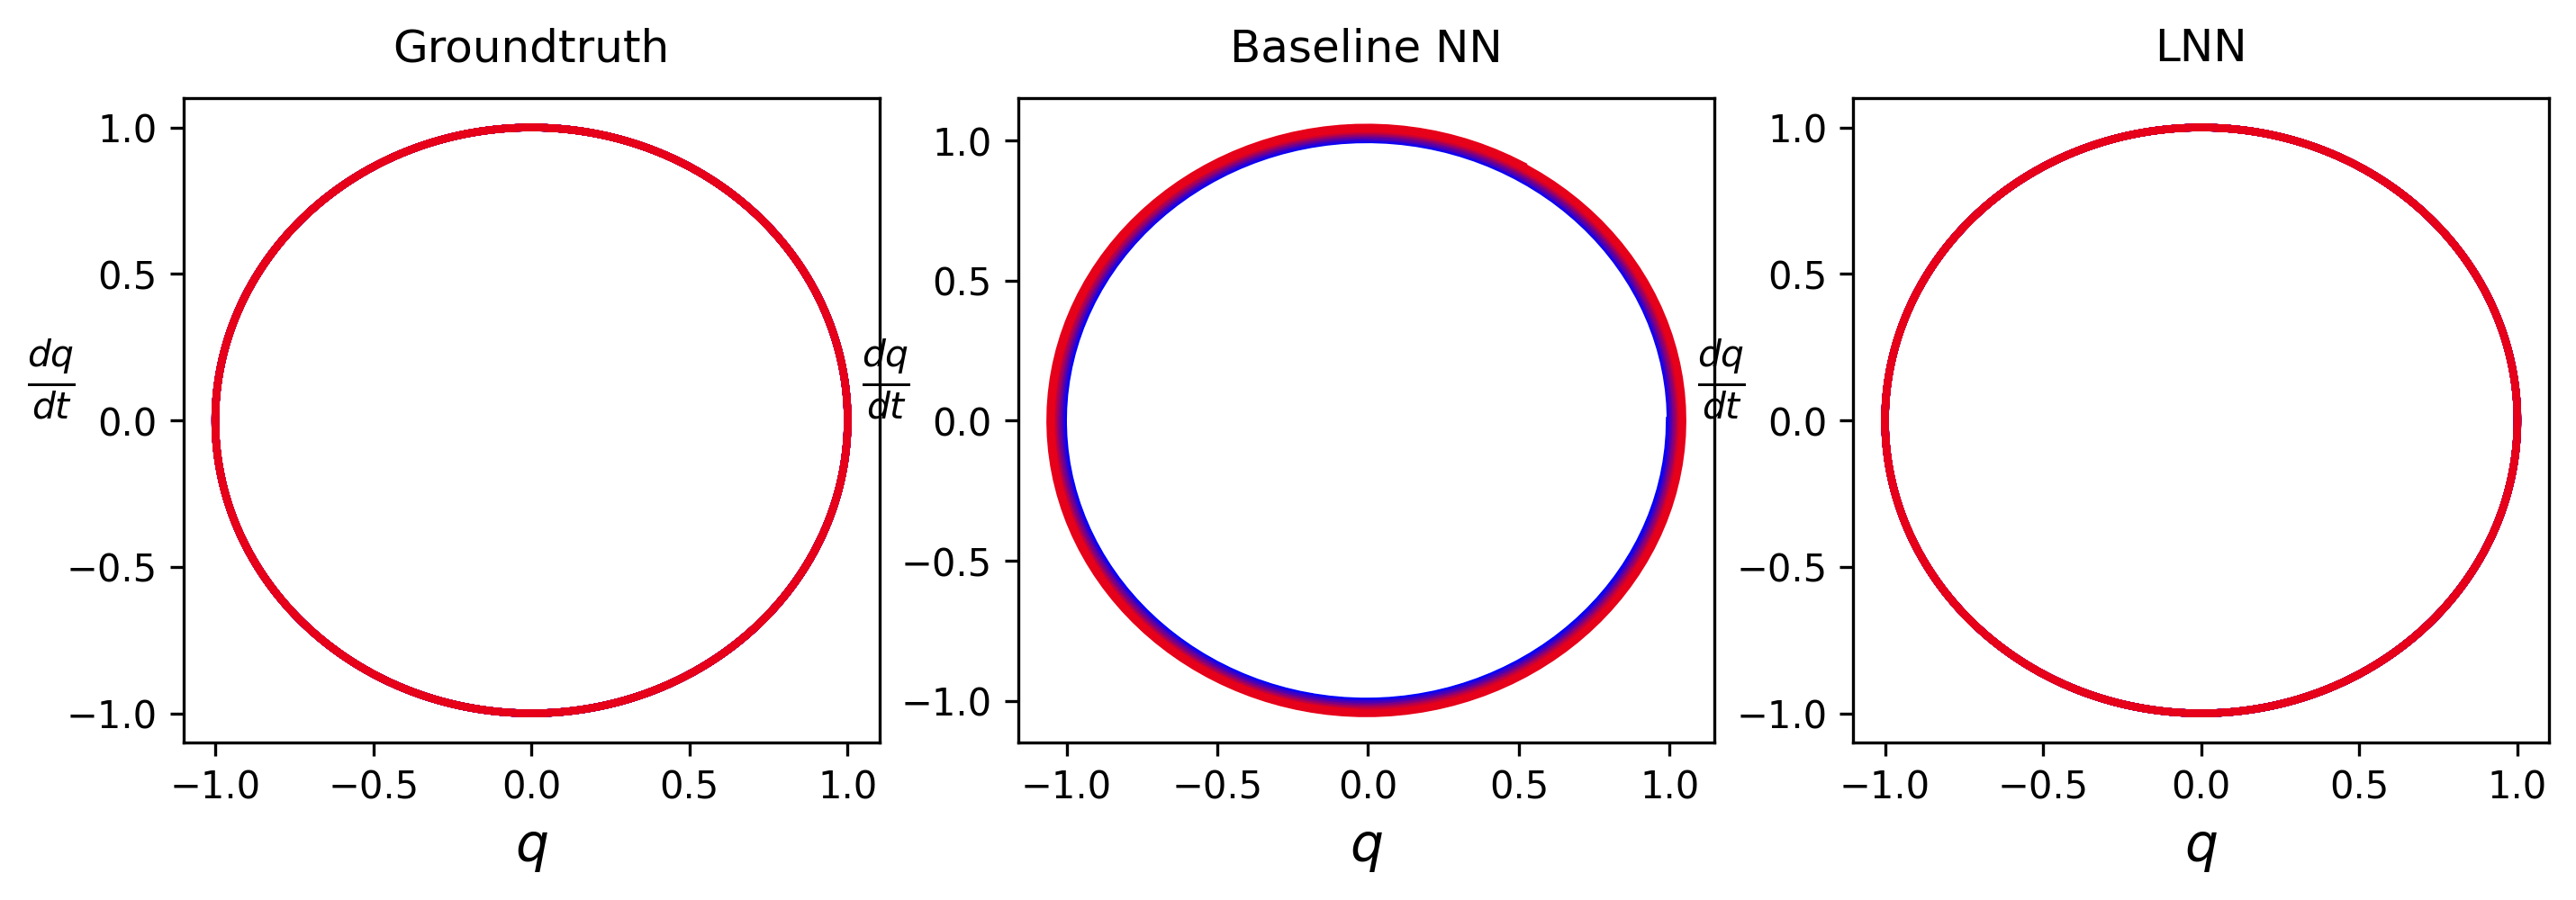

In [10]:
fig = plt.figure(figsize=(11.3, 3.1), facecolor='white', dpi=DPI)

#plot ground truth
fig.add_subplot(1, 3, 1, frameon=True)

for i, l in enumerate(np.split(integrate_['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1], color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$\\frac{dq}{dt}$", rotation=0, fontsize=14)
plt.title("Groundtruth", pad=10)

# plot baseline
fig.add_subplot(1, 3, 2, frameon=True)

for i, l in enumerate(np.split(integrate_model_bnn['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$\\frac{dq}{dt}$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot LNN
fig.add_subplot(1, 3, 3, frameon=True)

for i, l in enumerate(np.split(integrate_model_lnn['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$\\frac{dq}{dt}$", rotation=0, fontsize=14)
plt.title("LNN", pad=10)

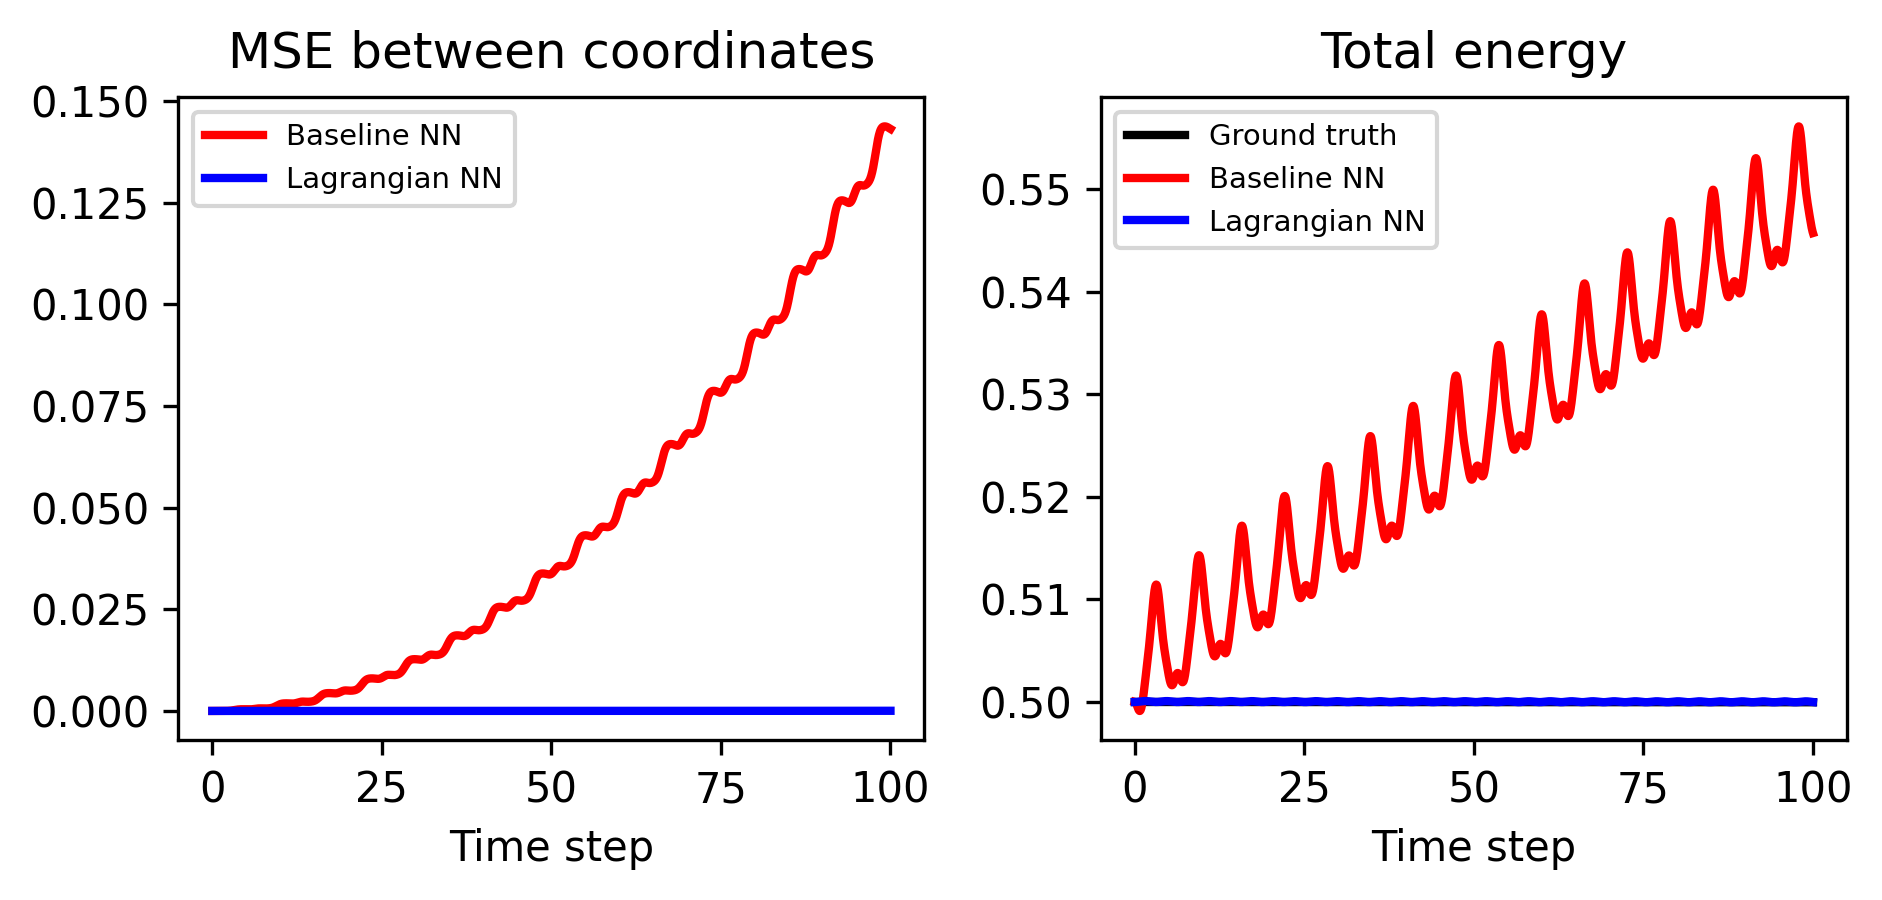

In [11]:
fig = plt.figure(figsize=(6.3, 3.1), facecolor='white', dpi=DPI)
tpad =7
noise_std = 0.0   #ノイズの設定を忘れないこと
t_span = [0,100]
y0 = np.asarray([1, 0])
t_eval=np.linspace(t_span[0], t_span[1], 2000)

# integrate along ground truth vector field
true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-12)
true_y = true_path['y'].T

# ノイズの影響を補正するために時間を再スケールする必要があることに注意
t_span[1] *= 1 + .7*noise_std
t_eval *= 1 + .7*noise_std

# integrate along baseline vector field
base_path = integrate_model(model_bnn, y0=y0, t_span=t_span, t_eval=t_eval, rtol=1e-12)
base_y = base_path['y'].T

# integrate along HNN vector field
lnn_path = integrate_model(model_lnn, y0=y0, t_span=t_span, t_eval=t_eval, baseline=False, rtol=1e-12)
lnn_y = lnn_path['y'].T

plt.subplot(1,2,1)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_y-base_y)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_y-lnn_y)**2).mean(-1), 'b-', label='Lagrangian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,2,2)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([total_energy(c) for c in true_y]).squeeze()
base_e = np.stack([total_energy(c) for c in base_y]).squeeze()
lnn_e = np.stack([total_energy(c) for c in lnn_y]).squeeze()
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, lnn_e, 'b-', label='Lagrangian NN', linewidth=2)
plt.legend(fontsize=7)
plt.tight_layout() ; plt.show()

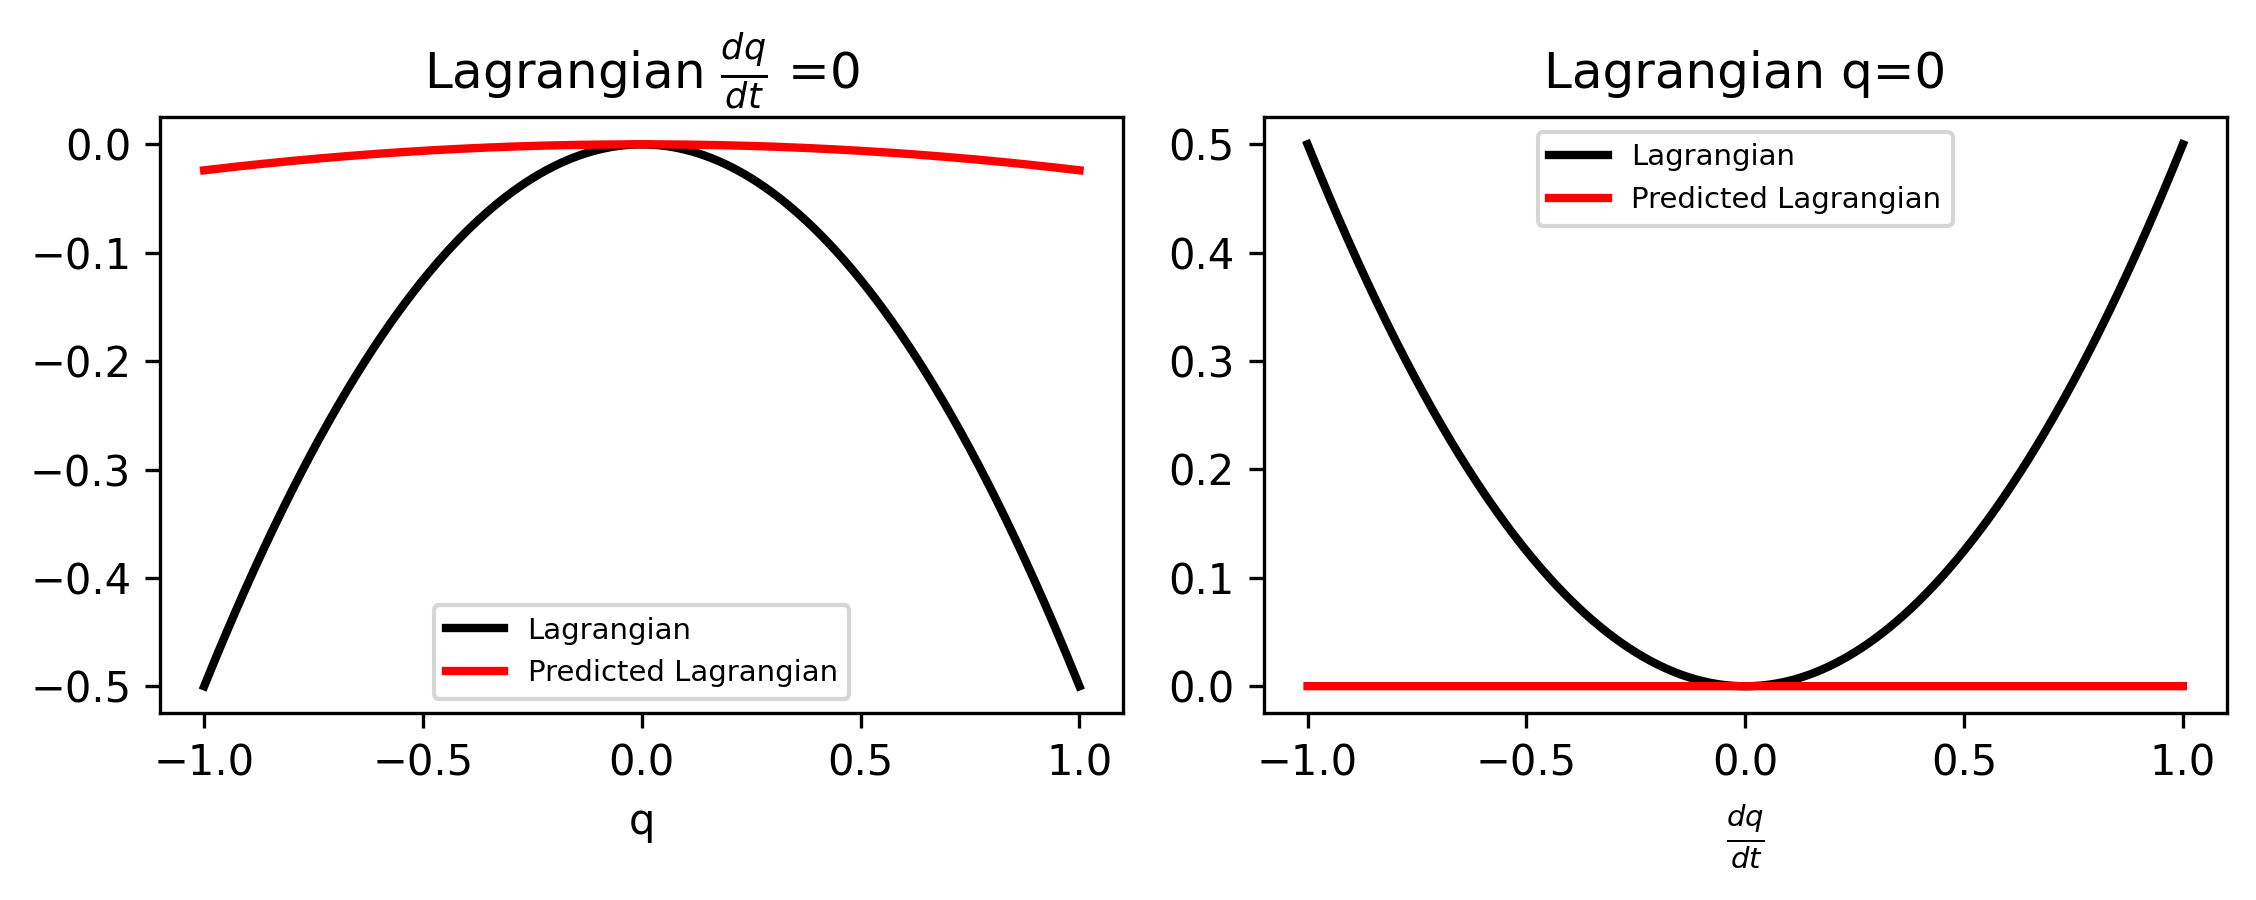

In [20]:
from numpy import linalg as LA
fig = plt.figure(figsize=(11.3, 3.1), facecolor='white', dpi=DPI)

plt.subplot(1,3,1)
plt.title("Lagrangian $\\frac{dq}{dt}$ =0", pad=tpad) ; plt.xlabel('q')
dqdt = 0
qs = np.linspace(-1, 1, 2000)
L_true =  np.stack([lagrangian_fn(np.array([q,dqdt])) for q in qs]).squeeze()
plt.plot(qs, L_true, 'k-', label='Lagrangian', linewidth=2)
coords = np.stack([np.array([q,dqdt]) for q in qs])
L_pred = model_lnn(torch.Tensor(coords)).detach().numpy().squeeze()
plt.plot(qs, L_pred, 'r-', label='Predicted Lagrangian', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,3,2)
plt.title("Lagrangian q=0", pad=tpad) ; plt.xlabel('$ \\frac{dq}{dt}$')
q = 0
dqdts = np.linspace(-1, 1, 2000)
L_true =  np.stack([lagrangian_fn(np.array([q,dqdt])) for dqdt in dqdts]).squeeze()
plt.plot(dqdts, L_true, 'k-', label='Lagrangian', linewidth=2)
coords = np.stack([np.array([q,dqdt]) for p in dqdts])
L_pred = model_lnn(torch.Tensor(coords)).detach().numpy().squeeze()
plt.plot(dqdts, L_pred, 'r-', label='Predicted Lagrangian', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()

In [13]:
import copy
model_bnn_ext, stats_bnn_ext = train(baseline=True, total_steps=3000, data=data_ext)
model_lnn_copy = copy.deepcopy(model_lnn)
model_forced_lnn, stats_forced_lnn = train(baseline=False, total_steps=9000, data=data_ext, ext=True, lnn_model_=model_lnn_copy)

Training baseline model:
step 0, train_loss 6.3698e-01, test_loss 3.4501e-02
step 200, train_loss 4.8539e-07, test_loss 2.2352e-02
step 400, train_loss 5.6547e-07, test_loss 2.7432e-02
step 600, train_loss 3.6590e-07, test_loss 3.1178e-02
step 800, train_loss 2.2949e-07, test_loss 2.4042e-02
step 1000, train_loss 3.6152e-07, test_loss 2.0764e-02
step 1200, train_loss 2.3294e-07, test_loss 3.7031e-02
step 1400, train_loss 3.2731e-07, test_loss 2.7652e-02
step 1600, train_loss 2.2757e-07, test_loss 2.3601e-02
step 1800, train_loss 3.7332e-07, test_loss 3.0109e-02
step 2000, train_loss 2.8451e-07, test_loss 2.5454e-02
step 2200, train_loss 6.6219e-07, test_loss 2.9767e-02
step 2400, train_loss 1.9309e-07, test_loss 2.3764e-02
step 2600, train_loss 2.2390e-07, test_loss 2.6150e-02
step 2800, train_loss 1.8377e-07, test_loss 2.8642e-02
step 3000, train_loss 9.6372e-07, test_loss 2.0078e-02
Final train loss 5.9201e-07 +/- 3.9168e-08
Final test loss 2.5947e-02 +/- 2.4770e-03
Training Forced L

In [14]:
print(model_forced_lnn.state_dict())

OrderedDict([('ext_model.w', tensor([[-1.3803e-09],
        [-9.1187e-10],
        [ 8.0784e-10],
        [ 8.4118e-06],
        [-2.3998e-04],
        [ 4.5636e-08]])), ('lnn_model.differentiable_model.w', tensor([[-2.4003e-02],
        [ 2.3998e-02],
        [-1.1374e-01],
        [-4.5620e-08],
        [-9.7966e-23],
        [ 8.8781e-05]]))])


In [15]:
integrate_ext = integrate(ext=True)
integrate_model_bnn_ext = integrate_model(model_bnn)
integrate_model_forced_lnn = integrate_model(model_forced_lnn, baseline=False)

Text(0.5, 1.0, 'Forced LNN')

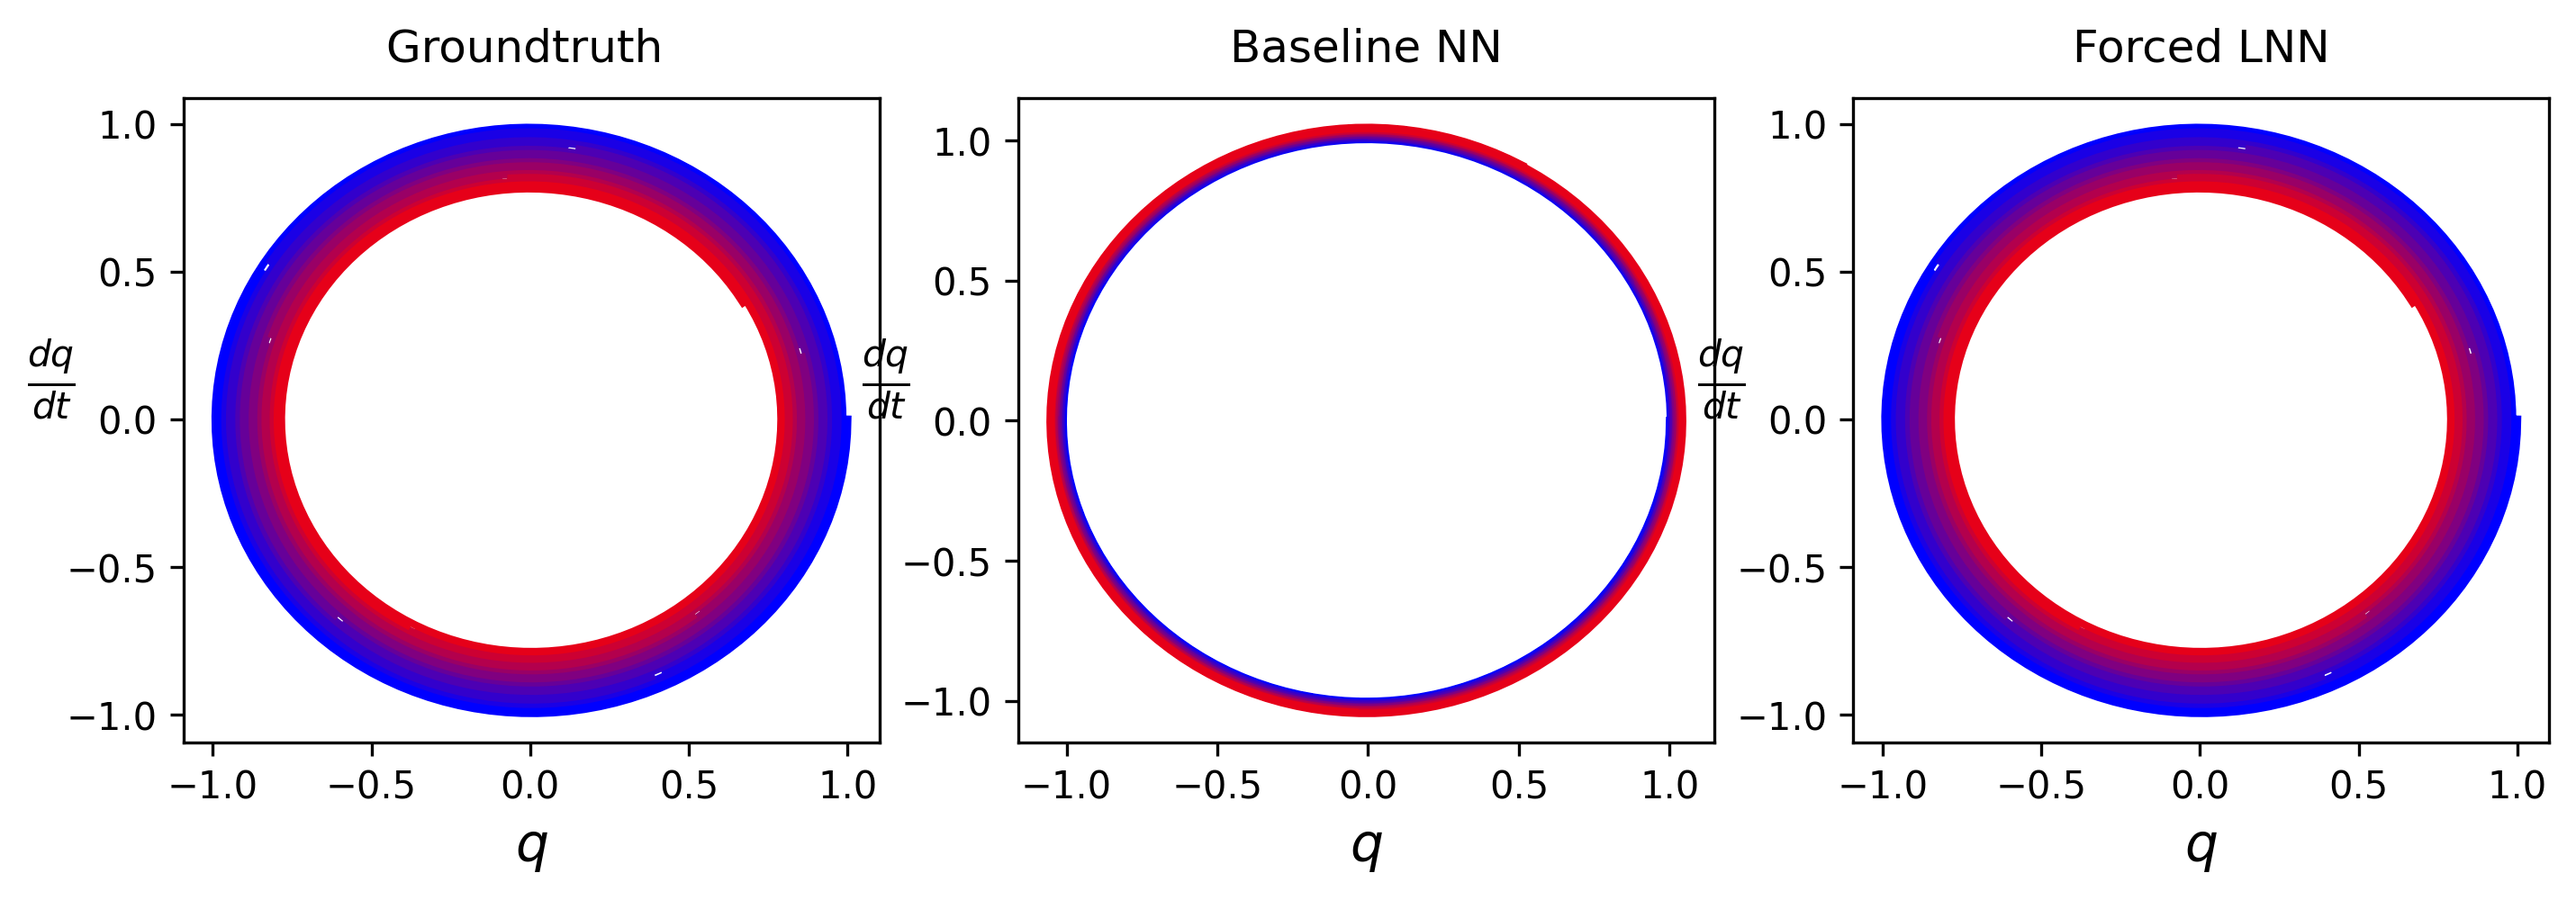

In [16]:
fig = plt.figure(figsize=(11.3, 3.1), facecolor='white', dpi=DPI)

#plot ground truth
fig.add_subplot(1, 3, 1, frameon=True)

for i, l in enumerate(np.split(integrate_ext['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1], color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$\\frac{dq}{dt}$", rotation=0, fontsize=14)
plt.title("Groundtruth ", pad=10)

# plot baseline
fig.add_subplot(1, 3, 2, frameon=True)

for i, l in enumerate(np.split(integrate_model_bnn_ext['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$\\frac{dq}{dt}$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot Forced LNN
fig.add_subplot(1, 3, 3, frameon=True)

for i, l in enumerate(np.split(integrate_model_forced_lnn['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$\\frac{dq}{dt}$", rotation=0, fontsize=14)
plt.title("Forced LNN", pad=10)

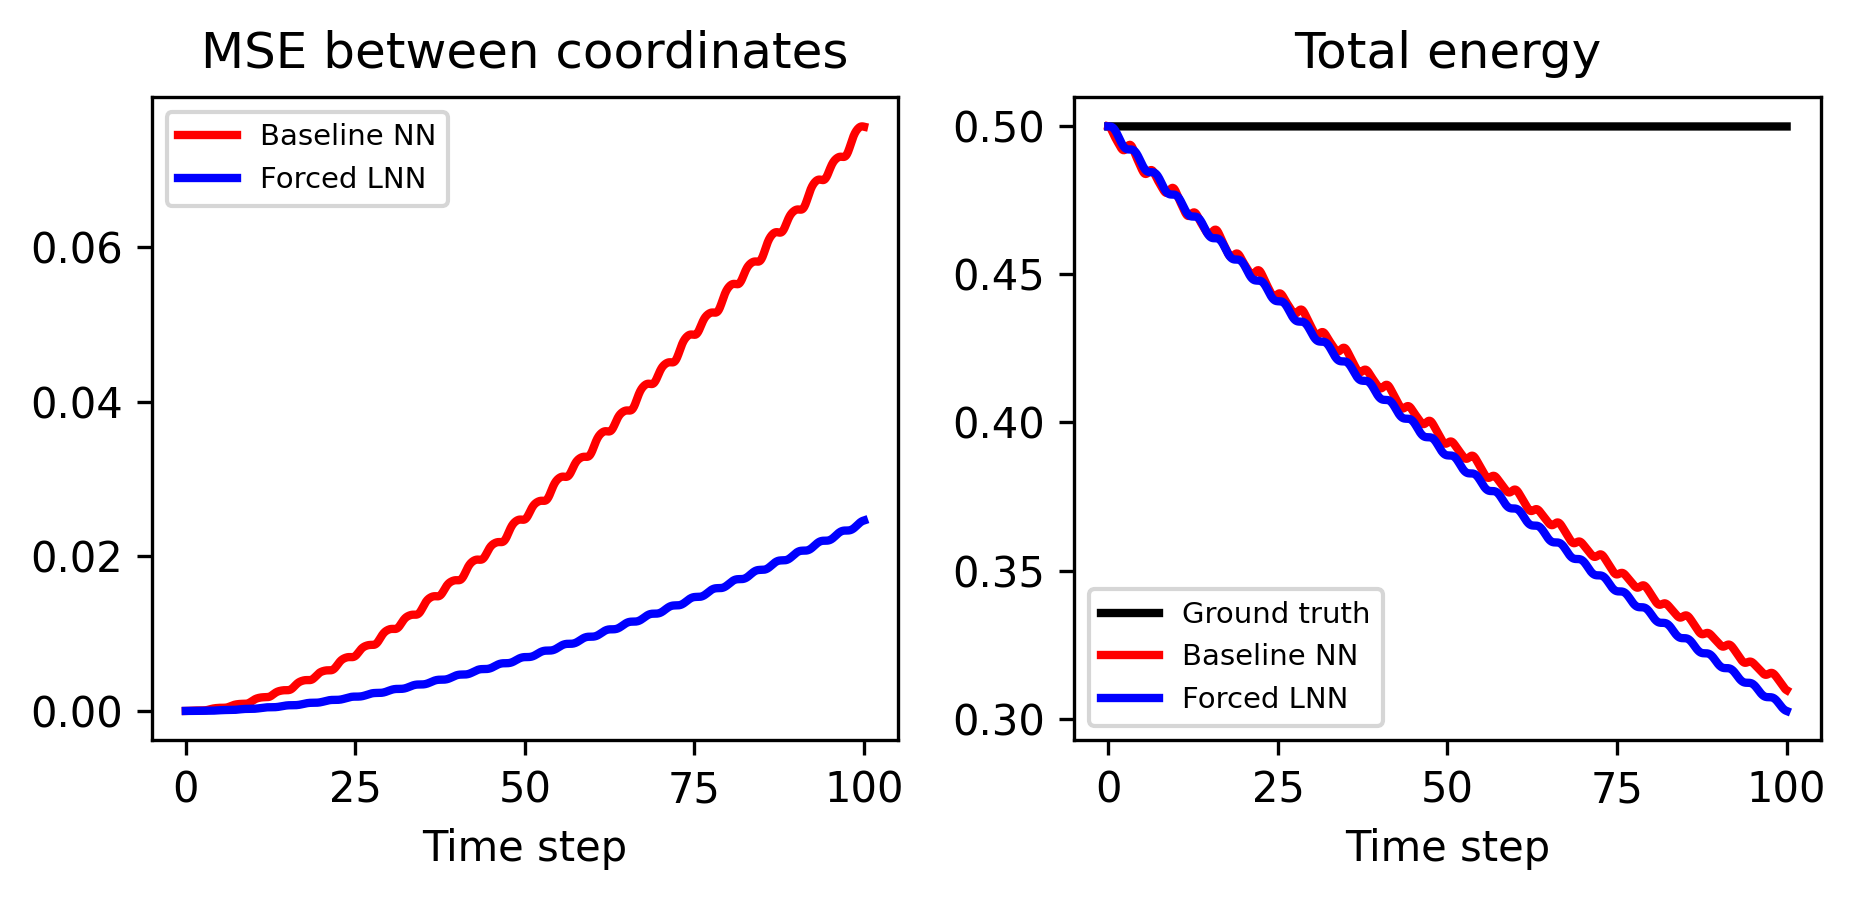

In [17]:
fig = plt.figure(figsize=(6.3, 3.1), facecolor='white', dpi=DPI)
tpad =7
noise_std = 0.0    #ノイズの設定を忘れないこと
t_span = [0,100]
y0 = np.asarray([1, 0])
t_eval=np.linspace(t_span[0], t_span[1], 2000)

# integrate along ground truth vector field
true_ext_path = solve_ivp(fun=dynamics_fn_ext, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-12)
true_ext_y = true_path['y'].T

# ノイズの影響を補正するために時間を再スケールする必要があることに注意
t_span[1] *= 1 + .7*noise_std
t_eval *= 1 + .7*noise_std

# integrate along baseline vector field
base_ext_path = integrate_model(model_bnn_ext, y0=y0, t_span=t_span, t_eval=t_eval, rtol=1e-12)
base_ext_y = base_ext_path['y'].T

# integrate along Forced LNN vector field
forced_lnn_path = integrate_model(model_forced_lnn, y0=y0, t_span=t_span, t_eval=t_eval, baseline=False, rtol=1e-12)
forced_lnn_y = forced_lnn_path['y'].T

plt.subplot(1,2,1)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_ext_y-base_ext_y)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_ext_y-forced_lnn_y)**2).mean(-1), 'b-', label='Forced LNN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,2,2)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_ext_e = np.stack([total_energy(c) for c in true_ext_y]).squeeze()
base_ext_e = np.stack([total_energy(c) for c in base_ext_y]).squeeze()
forced_lnn_e = np.stack([total_energy(c) for c in forced_lnn_y]).squeeze()
plt.plot(t_eval, true_ext_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_ext_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, forced_lnn_e, 'b-', label='Forced LNN', linewidth=2)
plt.legend(fontsize=7)
plt.tight_layout() ; plt.show()

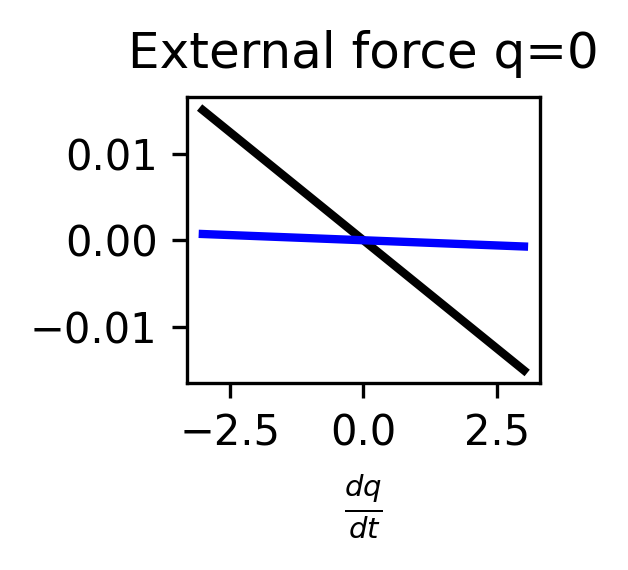

In [18]:
fig = plt.figure(figsize=(2, 2), facecolor='white', dpi=DPI)

plt.subplot(1,1,1)
plt.title("External force q=0", pad=tpad) ; plt.xlabel('$\\frac{dq}{dt}$')
q = 0
dqdts = np.linspace(-3, 3, 2000)
ext_true =  np.stack([ext_f(np.array([q,dqdt])) for dqdt in dqdts]).squeeze()
plt.plot(dqdts, ext_true, 'k-', label='External force', linewidth=2)
coords = np.stack([np.array([q,dqdt]) for dqdt in dqdts])
ext_pred = model_forced_lnn(torch.Tensor(coords)).detach().numpy().squeeze()
plt.plot(dqdts, ext_pred, 'b-', label='Predicted External force', linewidth=2)
coord = np.stack([np.array([dqdt]) for dqdt in dqdts])

plt.tight_layout() ; plt.show()